# Analyzing the Value Premium
February 2022

*July 2022 Note: Since the start of this notebook, the valuation spread between cheap and expensive stocks reverted further to the mean as additional inflationary pressure shifted the government yield curve upwards. Expensive stocks lost ~10% and cheap stocks were fairly flat. The value premium in small stocks has appreciated more than in large stocks.*

## Introduction
In 1992, Eugene Fama and Kenneth French introduced a Three-Factor Model in their famous paper "The Cross-Section of Expected Stock Returns" that extends William Sharpe's CAPM with a Size Factor (SMB) and a Value Factor (HML):
<br><br>
$$ E(r) = \alpha + \beta_{1} *  (MKT-R_f) + \beta_{2} * SMB + \beta_{3} * HML $$
<br>
Given the parsimonous structure, the theoretical existence of state variables that investors want to hedge against and the poor empirical performance of the CAPM, it has become, together with Fama/French's (FF) extended 5-Factor Model from 2015, the standard model to price the cross-section of equity returns.
<br>
However, since the publication of the paper, both factors failed to deliver any premium out-of-sample and the value premium (HML) in particular currently experiences a 20-year drawdown, erasing half of its entire 100-year cumulative outperformance. Sceptics claim that both premia are unrelated to risk and that the model is a result of data snooping. Once the existence of a new factor becomes common knowledge and investors adapt and try to exploit it, it should, via arbitrage, ultimately vanish. 
<br>
While asset pricing theory points to factors aside from the sensitivity to the market portfolio and although the four additional Fama/French factors are theoretically sound as they directly relate to the pricing equation, which in turn might point to a set of state variables in Robert Merton's ICAPM, it is unclear whether they can indeed proxy the underlying risk factors. This notebook puts the theory aside and provides a quantitative analysis of the drivers of the value premium and shows that the value premium still exists and is possibly a historically attractive diversifier in the current market environment.

**Table of Contents:**
1. [Descriptive&nbsp;Analysis](#1.&nbsp;Descriptive&nbsp;Analysis)
2. [Stochastic&nbsp;Analysis](#2.&nbsp;Stochastic&nbsp;Analysis)
3. [Relative&nbsp;Valuations](#3.&nbsp;Relative&nbsp;Valuations)
4. [Explaining&nbsp;Variables](#4.&nbsp;Explaining&nbsp;Variables)
5. [Time-Series&nbsp;Predictability](#5.&nbsp;Time-Series&nbsp;Predictability)
6. [ETF/Stock&nbsp;Selection](#6.&nbsp;ETF/Stock&nbsp;Selection)
7. [Summary](#7.&nbsp;Summary)

**Data sources:**
* [Kenneth French's Portfolio Database](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)
* [Robert Shiller's History of CAPE and Bond Rates](http://www.econ.yale.edu/~shiller/data.htm)

#### Importing the Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from scipy.stats import jarque_bera, norm, gaussian_kde
from finance_data import FrenchReader, MSCIReader, shiller_cape

In [3]:
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (12,6)

In [4]:
shiller_data = shiller_cape()[["10-Year Interest Rate", "CAPE", "CPI"]]
shiller_data["10-Year Interest Rate"] /= 100
ff3 = FrenchReader("F-F_Research_Data_Factors").read()["Main"] / 100
ff5 = FrenchReader("F-F_Research_Data_5_Factors_2x3").read()["Main"] / 100
mom = FrenchReader("F-F_Momentum_Factor").read()["Main"] / 100
df = pd.concat([ff3, mom, shiller_data], axis=1).dropna()
df["RMW"] = ff5["RMW"]
df["CMA"] = ff5["CMA"]
df = df[["Mkt-RF", "SMB", "HML", "RMW", "CMA", "Mom", "RF", "10-Year Interest Rate", "CAPE", "CPI"]]
df

,Mkt-RF,SMB,HML,RMW,CMA,Mom,RF,10-Year Interest Rate,CAPE,CPI
1927-01-01,-0.0006,-0.0051,0.0473,NaN,NaN,0.0036,0.0025,0.033400,13.185931,17.500
1927-02-01,0.0418,-0.0025,0.0327,NaN,NaN,-0.0214,0.0026,0.033392,13.633966,17.400
1927-03-01,0.0013,-0.0189,-0.0256,NaN,NaN,0.0361,0.0030,0.033383,14.033258,17.300
1927-04-01,0.0046,0.0049,0.0071,NaN,NaN,0.0430,0.0025,0.033375,14.488222,17.300
1927-05-01,0.0544,0.0146,0.0498,NaN,NaN,0.0300,0.0030,0.033367,15.002347,17.400
...,...,...,...,...,...,...,...,...,...,...
2022-01-01,-0.0625,-0.0593,0.1274,0.0073,0.0773,-0.0250,0.0000,0.017600,36.936758,281.148
2022-02-01,-0.0229,0.0218,0.0309,-0.0212,0.0299,0.0175,0.0000,0.019300,35.287165,283.716
2022-03-01,0.0306,-0.0161,-0.0182,-0.0132,0.0324,0.0298,0.0000,0.021300,34.270844,287.504
2022-04-01,-0.0945,-0.0140,0.0616,0.0351,0.0587,0.0488,0.0000,0.027500,33.889253,289.109


In [5]:
bm_sorted_data = FrenchReader("Portfolios_Formed_on_BE-ME").read()
bm_size_sorted_data = FrenchReader("6_Portfolios_2x3").read()

ep_sorted_data = FrenchReader("Portfolios_Formed_on_E-P").read()
ep_size_sorted_data = FrenchReader("6_Portfolios_ME_EP_2x3").read()

cfp_sorted_data = FrenchReader("Portfolios_Formed_on_CF-P").read()
cfp_size_sorted_data = FrenchReader("6_Portfolios_ME_CFP_2x3").read()

## 1.&nbsp;Descriptive&nbsp;Analysis

Starting with descriptive statistics, no factor of Fama/French's five-factor model, except for the equity premium itself, has delivered a significant premium since the publication of the respective model in 1992 and 2015, which questions the models out-of-sample performance to price equity risk.

In [6]:
print("Since 1992,...")
for factor in ("Mkt-RF", "SMB", "HML"):   
    ols_fit = OLS(df.loc["1992-01-01":, factor], [1 for _ in range(len(df.loc["1992-01-01":, :].index))]).fit()
    mean = ols_fit.params["const"]
    tstat = ols_fit.tvalues["const"]
    print(f"...the {factor} factor returned an average of {mean:.2%} per month with a t-statistic of {tstat:.2f}.")
print("")
print("Since 2015,...")
for factor in ("RMW", "CMA"):   
    ols_fit = OLS(df.loc["2015-01-01":, factor], [1 for _ in range(len(df.loc["2015-01-01":, :].index))]).fit()
    mean = ols_fit.params["const"]
    tstat = ols_fit.tvalues["const"]
    print(f"...the {factor} factor returned an average of {mean:.2%} per month with a t-statistic of {tstat:.2f}.")

Since 1992,...
...the Mkt-RF factor returned an average of 0.71% per month with a t-statistic of 3.13.
...the SMB factor returned an average of 0.11% per month with a t-statistic of 0.65.
...the HML factor returned an average of 0.25% per month with a t-statistic of 1.44.

Since 2015,...
...the RMW factor returned an average of 0.36% per month with a t-statistic of 1.72.
...the CMA factor returned an average of 0.13% per month with a t-statistic of 0.55.


While all four factors failed to deliver any premium out-of-sample, I will only discuss the value premium as it is the factor that has recently shown the worst performance and because it has a long tradition in equity markets, ranging back to Benjamin Graham in the early 20th century.

Since 2007, the value premium had its largest drawdown in history and shed about half of its entire cumulative outperformance since 1927 ...

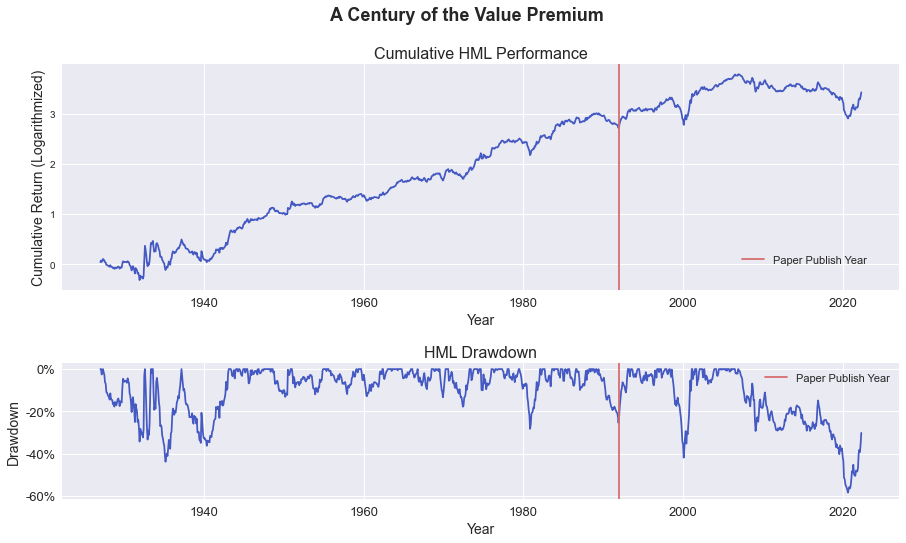

In [7]:
df["HML Cumulative"] = (1+df["HML"]).cumprod()
df["HML Drawdown"] = df["HML Cumulative"] / df["HML Cumulative"].cummax() - 1

figure, axes = plt.subplots(2, gridspec_kw={'height_ratios': [5, 3]}, figsize=(15,8))
plt.subplots_adjust(hspace=0.4)
figure.suptitle("A Century of the Value Premium", fontsize=18, fontweight="bold")

axes[0].plot(np.log(df["HML Cumulative"]), color="#4459c2")
axes[0].axvline(x=(1992-1970)*365, label="Paper Publish Year", color="#d66b6b")

axes[0].set_title("Cumulative HML Performance", size=16)
axes[0].set_xlabel("Year", size=14)
axes[0].set_ylabel("Cumulative Return (Logarithmized)", size=14)
axes[0].tick_params(axis="x", labelsize=13)

axes[0].legend(fontsize=11, bbox_to_anchor=(0.8,0.2));

axes[1].plot(df["HML Drawdown"], color="#4459c2")
axes[1].axvline(x=(1992-1970)*365, label="Paper Publish Year", color="#d66b6b")

axes[1].set_title("HML Drawdown", size=16)
axes[1].set_xlabel("Year", size=14)
axes[1].set_ylabel("Drawdown", size=14)
axes[1].tick_params(axis="x", labelsize=13)

yticks = [-0.6,-0.4,-0.2, 0]
axes[1].set_yticks(yticks)
axes[1].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)

axes[1].legend(fontsize=11, loc="upper right");

... and the failure of the value premium was both present in large and small caps, although higher in magnitude in the large cap segment.

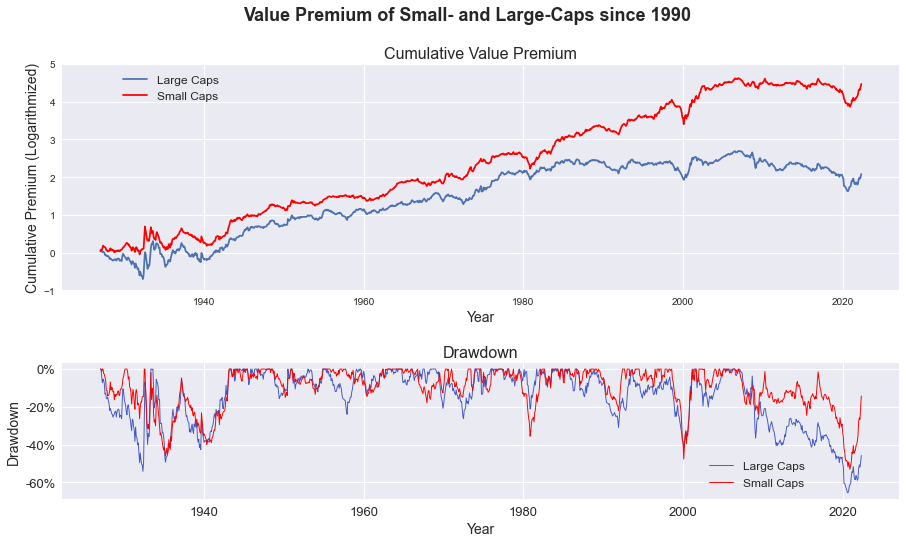

In [8]:
df["Large High B/M"] = bm_size_sorted_data["Average Value Weighted Returns Monthly"]["BIG HiBM"] / 100
df["Large Low B/M"] = bm_size_sorted_data["Average Value Weighted Returns Monthly"]["BIG LoBM"] / 100
df["Small High B/M"] = bm_size_sorted_data["Average Value Weighted Returns Monthly"]["SMALL HiBM"] / 100
df["Small Low B/M"] = bm_size_sorted_data["Average Value Weighted Returns Monthly"]["SMALL LoBM"] / 100

df["Large Value Premium"] = df["Large High B/M"] - df["Large Low B/M"] 
df["Large Value Premium Cumulative"] = (1+df["Large Value Premium"]).cumprod()
df["Small Value Premium"] = df["Small High B/M"] - df["Small Low B/M"]
df["Small Value Premium Cumulative"] = (1+df["Small Value Premium"]).cumprod()

df["Large Value Premium Drawdown"] = df["Large Value Premium Cumulative"] / df["Large Value Premium Cumulative"].cummax() - 1
df["Small Value Premium Drawdown"] = df["Small Value Premium Cumulative"] / df["Small Value Premium Cumulative"].cummax() - 1

figure, axes = plt.subplots(2, gridspec_kw={'height_ratios': [5, 3]}, figsize=(15,8))
plt.subplots_adjust(hspace=0.4)
figure.suptitle("Value Premium of Small- and Large-Caps since 1990", fontsize=18, fontweight="bold")

axes[0].plot(np.log((1+df["Large Value Premium"]).cumprod()), label="Large Caps")
axes[0].plot(np.log((1+df["Small Value Premium"]).cumprod()), label="Small Caps", color="red")

axes[0].set_title("Cumulative Value Premium", size=16)
axes[0].set_xlabel("Year", fontsize=14)
axes[0].set_ylabel("Cumulative Premium (Logarithmized)", fontsize=14)

yticks1 = axes[0].get_yticks().tolist()
axes[0].set_yticks(yticks1)
axes[0].legend(fontsize=12, bbox_to_anchor=(0.2, 1))

axes[1].plot(df["Large Value Premium Drawdown"], color="#4459c2", linewidth=0.95, label="Large Caps")
axes[1].plot(df["Small Value Premium Drawdown"], color="red", linewidth=0.95, label="Small Caps")

axes[1].set_title("Drawdown", size=16)
axes[1].set_xlabel("Year", size=14)
axes[1].set_ylabel("Drawdown", size=14)
axes[1].tick_params(axis="x", labelsize=13)

yticks = [-0.6,-0.4,-0.2, 0]
axes[1].set_yticks(yticks)
axes[1].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)
axes[1].legend(fontsize=12, bbox_to_anchor=(0, 0, 0.9, 0.98));

While some people argue that book values are a flawed measure of valuations as highly profitable technology companies with low capital requirements and hence low book-values become more relevant today, the drawdowns look similar if we take net-earnings or cashflows instead of book-values.
<br>
However, the recent drawdowns of value premia based on E/P and CF/P start a few years later and are not as large in magnitude as the recent drawdown of the book-value-based value premium.
<br>
*(Note that the data for other variables is constrained to a later starting date)*

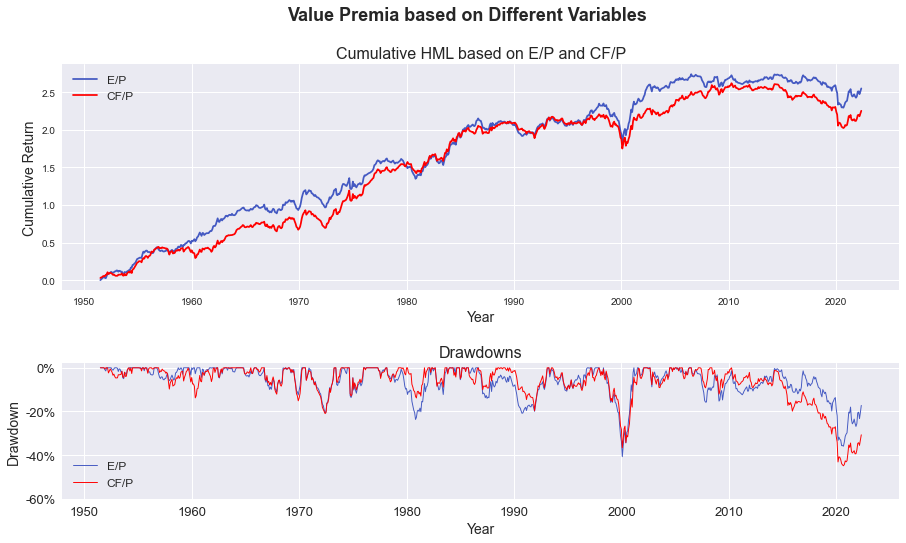

In [9]:
df["Large Value Premium E/P"] = (ep_size_sorted_data["Value Weight Average Returns Monthly"]["BIG HiEP"] - ep_size_sorted_data["Value Weight Average Returns Monthly"]["BIG LoEP"]) / 100
df["Large Value Premium E/P Cumulative"] = (1+df["Large Value Premium E/P"]).cumprod()
df["Small Value Premium E/P"] = (ep_size_sorted_data["Value Weight Average Returns Monthly"]["SMALL HiEP"] - ep_size_sorted_data["Value Weight Average Returns Monthly"]["SMALL LoEP"]) / 100
df["Small Value Premium E/P Cumulative"] = (1+df["Small Value Premium E/P"]).cumprod()

df["HML E/P"] = (df["Large Value Premium E/P"] + df["Small Value Premium E/P"]) / 2
df["HML E/P Cumulative"] = (1+df["HML E/P"]).cumprod()
df["HML E/P Drawdown"] = df["HML E/P Cumulative"] / df["HML E/P Cumulative"].cummax() - 1

df["Large Value Premium CF/P"] = (cfp_size_sorted_data["Value Weight Average Returns Monthly"]["BIG HiCFP"] - cfp_size_sorted_data["Value Weight Average Returns Monthly"]["BIG LoCFP"]) / 100
df["Large Value Premium CF/P Cumulative"] = (1+df["Large Value Premium CF/P"]).cumprod()
df["Small Value Premium CF/P"] = (cfp_size_sorted_data["Value Weight Average Returns Monthly"]["SMALL HiCFP"] - cfp_size_sorted_data["Value Weight Average Returns Monthly"]["SMALL LoCFP"]) / 100
df["Small Value Premium CF/P Cumulative"] = (1+df["Small Value Premium CF/P"]).cumprod()

df["HML CF/P"] = (df["Large Value Premium CF/P"] + df["Small Value Premium CF/P"]) / 2
df["HML CF/P Cumulative"] = (1+df["HML CF/P"]).cumprod()
df["HML CF/P Drawdown"] = df["HML CF/P Cumulative"] / df["HML CF/P Cumulative"].cummax() - 1

figure, axes = plt.subplots(2, figsize=(15,8), gridspec_kw={'height_ratios': [5,3]})
plt.subplots_adjust(hspace=0.4)
figure.suptitle("Value Premia based on Different Variables", fontsize=18, fontweight="bold")

axes[0].plot(np.log(df["HML E/P Cumulative"]), color="#4459c2", label="E/P")
axes[0].plot(np.log(df["HML CF/P Cumulative"]), color="red", label="CF/P")
axes[0].set_title("Cumulative HML based on E/P and CF/P", size=16)
axes[0].set_xlabel("Year", size=14)
axes[0].set_ylabel("Cumulative Return", size=14)
axes[0].legend(fontsize=12)

axes[1].plot(df["HML E/P Drawdown"], color="#4459c2", linewidth=0.95, label="E/P")
axes[1].plot(df["HML CF/P Drawdown"], color="red", linewidth=0.95, label="CF/P")

axes[1].set_title("Drawdowns", size=16)
axes[1].set_xlabel("Year", size=14)
axes[1].set_ylabel("Drawdown", size=14)
axes[1].tick_params(axis="x", labelsize=13)

yticks = [-0.6,-0.4,-0.2, 0]
axes[1].set_yticks(yticks)
axes[1].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)
axes[1].legend(fontsize=12);

The correlations between alternative measures of the value premium also highlight that it does not matter which fundamental variable we use to measure the value premium.

In [10]:
np.round(df[["HML", "HML E/P", "HML CF/P"]].corr(), 2)

,HML,HML E/P,HML CF/P
HML,1.00,0.85,0.83
HML E/P,0.85,1.00,0.89
HML CF/P,0.83,0.89,1.00


To sum it up, the value factor has been terrible recently, no matter of the size of the companies and the variable used. However, there are at least two arguments, considered individually or together, that might invalidate the claim that the recent data points to a vanished value premium:
1. The underperformance is the result of chance.
2. Macroeconomic/fundamentals shifts affected cheap and expensive stocks differently, resulting either in changing valuations or in different unexpected underlying fundamental performances of the companies.

## 2.&nbsp;Stochastic&nbsp;Analysis

Given that all factors carry a sizable amount of risk in the form of volatility, it should be no surprise that a factor, described by a stochastic process with positive mean can underperform for a lengthy period. For example, for an iid normally distributed white noise process with a yearly mean return of 10% and 20% yearly volatility, there is still a probability of 2% that the process realizes a mean return <0 over a period of 15 years. Likewise, the US market portfolio showed multiple periods of 15-year underperformance against bonds.
<br>
Let's analyze the probability that the HML underperformance is due to chance:

Pior to publication in 1992, the Value Premium had delivered an average monthly excess return of

In [11]:
prior_mean = df.loc[:"1992-01-01", "HML"].mean()
print(f"{prior_mean:.2%}")

0.42%


with a monthly volatility of

In [12]:
prior_std = df.loc[:"1992-01-01", "HML"].std()
print(f"{prior_std:.2%}.")

3.68%.


Assuming a gaussian distribution and stationarity pre- and post publication (i.e. the same mean and volatility pre- and post-publication), we can compute the probability that the value premium returns an average below the realized average post-publication. Given the increasing number of factor ETFs to give retail investors access to alternative factor premia and investors needing some time to fully adapt to new academic research, I do the same for the subsamples of 1997, 2002, 2007 onwards.

In [13]:
print("The respective sample size of each considered subsample is as follows:\n")
for year in (1992, 1997, 2002, 2007):
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    print(f"The sample size spanning from January {year} to today is {sample_size} months.")

The respective sample size of each considered subsample is as follows:

The sample size spanning from January 1992 to today is 365 months.
The sample size spanning from January 1997 to today is 305 months.
The sample size spanning from January 2002 to today is 245 months.
The sample size spanning from January 2007 to today is 185 months.


Turning to the probabilities, we get the following values.

In [14]:
for year in (1992, 1997, 2002, 2007):
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    std_err = df.loc[f"{year}-01-01":, "HML"].std() / np.sqrt(sample_size)
    realized_mean = df.loc[f"{year}-01-01":, "HML"].mean()
    mean_diff = realized_mean - prior_mean
    z_value = mean_diff / std_err
    p_value = norm.cdf(z_value)
    print(f"For the subsample from January {year} to today, the probability of an average return less than {realized_mean:.2%} per month is {p_value:.2%}")

For the subsample from January 1992 to today, the probability of an average return less than 0.25% per month is 16.33%
For the subsample from January 1997 to today, the probability of an average return less than 0.15% per month is 8.49%
For the subsample from January 2002 to today, the probability of an average return less than 0.05% per month is 2.80%
For the subsample from January 2007 to today, the probability of an average return less than -0.14% per month is 1.05%


So far, one could certainly (and possibly unsurpringly) conclude at some reasonable confidence level that the value premium has a structural break (i.e. a mean-shift) between pre- and post-publication of the paper.
However, running the same for a hypothesis of a zero mean-return post-publication gives the following results:

In [15]:
for year in (1992, 1997, 2002, 2007):
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    std_err = df.loc[f"{year}-01-01":, "HML"].std() / np.sqrt(sample_size)
    realized_mean = df.loc[f"{year}-01-01":, "HML"].mean()
    mean_diff = realized_mean - 0
    z_value = mean_diff / std_err
    p_value = norm.cdf(z_value)
    print(f"For the subsample from January {year} to today, the probability of an average return less than {realized_mean:.2%} per month is {p_value:.2%}")

For the subsample from January 1992 to today, the probability of an average return less than 0.25% per month is 92.53%
For the subsample from January 1997 to today, the probability of an average return less than 0.15% per month is 77.48%
For the subsample from January 2002 to today, the probability of an average return less than 0.05% per month is 60.78%
For the subsample from January 2007 to today, the probability of an average return less than -0.14% per month is 28.04%


Therefore, based on the assumptions and the data, it is not possible to argue that the value premium is dead.
<br>
One issue though is that the empirical distribution of the value premium, like many financial time-series, is non-normal, although I assumed normality until now.

Its skewness is

In [16]:
prior_skew = df.loc[:"1992-01-01", "HML"].skew()
np.round(prior_skew, 2)

2.73

and its excess kurtosis is

In [17]:
prior_kurt = df.loc[:"1992-01-01", "HML"].kurt()
print(np.round(prior_kurt, 2), ",", sep="")

22.91,


both well above that of a normal distribution. Accordingly, a jarque-bera test easily rejects the hypothesis of a normal distribution at the 1% level:

In [18]:
jb = jarque_bera(df.loc[:"1992-01-01", "HML"]).pvalue
print(f"{jb:.2%}")

0.00%


The empirical distribution compared to a normal distribution with same mean and variance also highlights the empirical leptokurtic structure:

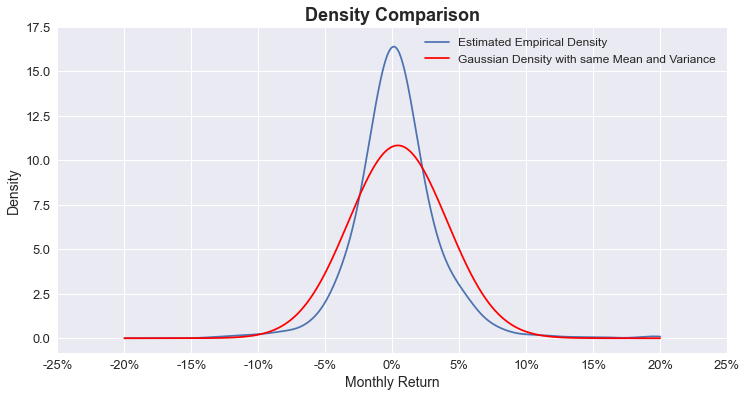

In [19]:
estimated_density = gaussian_kde(df.loc[:"1992-01-01", "HML"])

x = np.linspace(-0.2, 0.2, 1000)
plt.plot(x, estimated_density(x), label="Estimated Empirical Density")
plt.plot(x, norm.pdf(x, prior_mean, prior_std), label="Gaussian Density with same Mean and Variance", color="red")

plt.title("Density Comparison", fontsize=18, fontweight="bold")
plt.ylabel("Density", fontsize=14)
plt.xlabel("Monthly Return", fontsize=14)

xticks = plt.xticks()[0]
plt.xticks(xticks, [f"{ret:.0%}" for ret in xticks], fontsize=13)
yticks = plt.yticks()[0]
plt.yticks(yticks[1:], yticks[1:], fontsize=13)

plt.legend(fontsize=12);

Therefore, it is important to account for the non-normality and compute the same probabilities before by incorporating the empirical distribution instead of assuming normality. For that, I bootstrap intervals by drawing n times (n=sample size) with replacement from the empirical distribution until January 1992. I do it 100.000 times for each subsample and compute the probability of an average return less than the respective realized return by counting the ocurrences and diving it by the total number of bootstrap samples..

In [20]:
series = {}
sample_size = df.loc["1992-01-01":, "HML"].count()
for i in range(100_000):
    series[i] = pd.Series(np.random.choice(df.loc[:f"1992-01-01", "HML"], sample_size))
bootstrapped_df = pd.DataFrame(series)
bootstrapped_df

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,-0.0102,-0.0144,0.0057,-0.0273,0.3561,0.0336,0.0047,-0.0367,-0.0113,0.0007,...,-0.0405,0.0061,0.0286,0.0041,-0.0107,-0.0552,-0.0109,-0.0310,0.0522,-0.0074
1,0.0336,0.0176,-0.0591,0.0059,-0.0146,0.0106,0.0262,0.0342,0.0007,0.0300,...,0.0036,-0.0020,0.0239,-0.0161,0.0227,-0.0244,0.3424,0.0001,-0.0319,0.0240
2,0.0396,0.0664,0.0175,0.0044,-0.0171,-0.0076,-0.0110,-0.0242,0.0054,0.0012,...,0.0054,-0.0282,-0.0659,-0.0310,0.0042,-0.0012,-0.0074,0.0857,0.0228,-0.0079
3,-0.0111,0.0043,-0.0008,0.0002,0.0633,-0.0421,0.0075,-0.0256,0.0160,-0.0065,...,-0.0122,0.0404,0.0213,0.0100,0.0093,0.0023,-0.0034,-0.0049,0.0181,0.0033
4,-0.0089,-0.0039,-0.0230,0.0433,0.0019,0.0140,0.0023,-0.0035,-0.0270,-0.0006,...,-0.0166,-0.0142,-0.0122,0.0055,0.0351,-0.0085,0.0036,0.0039,-0.0122,-0.0043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.0085,0.0036,0.0312,-0.0192,-0.0507,-0.0124,0.0027,-0.0021,0.0470,-0.0161,...,-0.0242,-0.0073,-0.0035,0.0077,0.0181,-0.0027,0.0453,0.0033,0.0304,-0.0079
361,0.0053,0.0064,-0.0114,-0.0142,0.0388,0.0043,0.0498,-0.0192,0.0225,0.0118,...,0.0507,-0.0122,-0.0188,-0.0594,0.0051,-0.0311,-0.0001,0.0214,0.0132,0.0333
362,-0.0074,0.3561,0.0404,0.0551,0.0187,-0.0011,-0.0162,-0.0327,0.0070,0.0127,...,-0.0433,-0.0242,0.0090,0.0124,-0.0124,0.0725,-0.0284,-0.0110,-0.0256,0.0157
363,0.0000,-0.0080,0.0433,-0.0837,-0.0473,0.0012,0.0173,-0.0064,0.0135,-0.0001,...,0.0066,0.0164,-0.0284,-0.0327,0.0097,0.0085,-0.0098,-0.0178,0.0319,0.0063


In [21]:
for year in (1992, 1997, 2002, 2007):
    realized_mean = df.loc[f"{year}-01-01":, "HML"].mean()
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    prob = (bootstrapped_df.iloc[:sample_size, :].mean().sort_values().reset_index(drop=True) < realized_mean).sum() / 100_000
    print(f"For the subsample from January {year} to today, the probability of an average return less than {realized_mean:.2%} per month is {prob:.2%}")

For the subsample from January 1992 to today, the probability of an average return less than 0.25% per month is 19.09%
For the subsample from January 1997 to today, the probability of an average return less than 0.15% per month is 9.69%
For the subsample from January 2002 to today, the probability of an average return less than 0.05% per month is 5.45%
For the subsample from January 2007 to today, the probability of an average return less than -0.14% per month is 1.50%


And the same results in graphical representation look as follows:

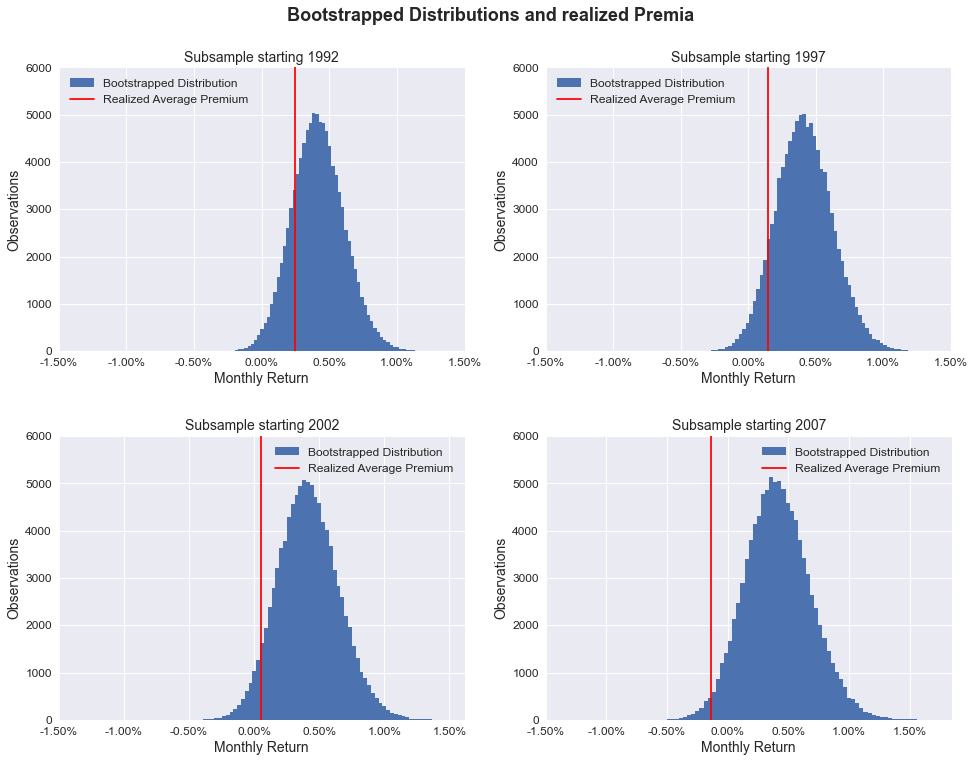

In [22]:
figure, axes = plt.subplots(2, 2, figsize=(16,12))
plt.subplots_adjust(hspace=0.3)
figure.suptitle("Bootstrapped Distributions and realized Premia", fontsize=18, fontweight="bold", y=0.95)

for year, (x, y) in zip((1992, 1997, 2002, 2007), ((0,0), (0,1), (1,0), (1,1))):
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    axes[x,y].hist(bootstrapped_df.iloc[:sample_size, :].mean(), bins=70, label="Bootstrapped Distribution")
    axes[x,y].axvline(df.loc[f"{year}-01-01":, "HML"].mean(), color="red", label="Realized Average Premium")
    
    axes[x,y].set_title(f"Subsample starting {year}", fontsize=14)
    axes[x,y].set_xlabel("Monthly Return", fontsize=14)
    axes[x,y].set_ylabel("Observations", fontsize=14)
    
    xticks = np.linspace(-0.015, 0.015, 7)
    axes[x,y].set_xticks(xticks)
    axes[x,y].set_xticklabels([f"{ret:.2%}" for ret in xticks], fontsize=12)
    yticks = axes[x,y].get_yticks().tolist()
    axes[x,y].set_yticks(yticks)
    axes[x,y].set_yticklabels([int(obs) for obs in yticks], fontsize=12)
    
    axes[x,y].legend(fontsize=12)

Although the probabilities are a bit higher than when I assumed normality, the main message remains the same and the post-publication value premium is either a statistical outlier or the process exhibits a structural mean-shift. However, as I have shown, the hypothesis that the post-publication mean return is zero cannot be rejected (which can also be seen if we shift the boostrapped distributions to the left so that it has a zero mean). Therefore, looking at the mere data, there is no indication of a dead value premium.

## 3.&nbsp;Relative&nbsp;Valuations

While a basket of stocks with the same characteristics (e.g. same magnitude of market beta) should deliver its expected premium over the long term, it can deviate quite a lot from that over the shorter term for various reasons. Valuations of stocks change continuously as the business cycle affects the discount rate, new news getting priced in and many other factors.
<br>
The shorter the period, the higher is the effect of changing valuations compared to the embedded premium on returns.
For example, the daily equity premium is a few basis points and the volatility of around 100 basis points dominates, but over decades, positive and negative shocks cancel each other out and the premium overweighs. For example, following the financial crisis 2008/09, the realized US equity premium was well above its historical average since it benefited quite a lot from changes in valuations.

The US equity premium from 1927 to today was

In [23]:
equity_premium = df["Mkt-RF"].mean()*12
print(f"{equity_premium:.2%},")

8.08%,


while the average from 2009 to today was

In [24]:
equity_premium_recent = df.loc["2009-01-01": , "Mkt-RF"].mean()*12
print(f"{equity_premium_recent:.2%},")

14.14%,


or

In [25]:
sigma = ((df["Mkt-RF"].std() * np.sqrt(12)) / np.sqrt(df.loc["2009-01-01": , "Mkt-RF"].count()/12))
np.round((equity_premium_recent - equity_premium) / sigma, 2)

1.2

standard deviations above its expected value using the full sample mean and assuming normality.

Accordingly, a large portion of US stock returns since 2009 have been the result of changing valuations, measured in terms of the [CAPE](https://www.nber.org/system/files/working_papers/w8221/w8221.pdf) (which is a function of risk aversion and expected earnings growth), and not by fundamental drivers such as abnormally high realized earnings growth or dividends.

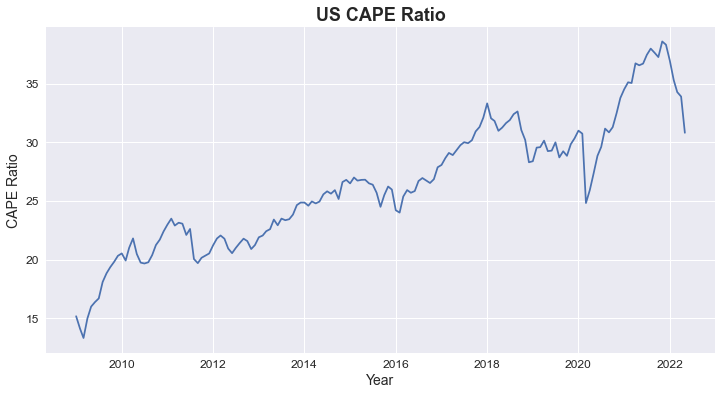

In [26]:
plt.plot(df.loc["2009-01-01":, "CAPE"])

plt.title("US CAPE Ratio", fontsize=18, fontweight="bold")
plt.ylabel("CAPE Ratio", fontsize=14)
plt.xlabel("Year", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In a similar fashion, the realized value premium is the result of three factors:
1. The difference of the embedded ex-ante risk premia between low-valued and high-valued stocks
2. The change in relative valuations due to changing expectations
3. Unexpected fundamental changes that do not affect the relative valuations, e.g. a one-time shock that affect earnings but do not affect expectations going forward and hence also not affect relative valuations
<br>

Again, over a long enough sample, (2) and (3) should have little effect, but over the short term, they can be the main driver of the value premium.

To gain inside, we can take a look at the relative valuations of stocks with high book-to-market ratios and those with low book-to-market ratios, both in small- and large-caps. I use 30th-percentile and 70th-percentile book-to-market data for growth- and value-stocks, respectively, provided by Kenneth French on an annual basis computed at the end of June and fill the data in-between with the realized value premium.
<br>
It becomes clear that relative valuations increased dramatically since the start of the HML drawdown in January 2007 with relative valuations widening between 200% and 250% and that the current level is similar to that of the 2000 dotcom bubble and the great depression in the 1930s.

In [27]:
spreads = pd.DataFrame(index = df.index)

spreads["High B/M Ratio"] = bm_sorted_data["Value Weight Average of BE / ME"]["Hi 30"]
spreads["Low B/M Ratio"] = bm_sorted_data["Value Weight Average of BE / ME"]["Lo 30"]

spreads["Large High B/M Ratio"] = bm_size_sorted_data["Value Weight Average of BE/ME"]["BIG HiBM"][bm_size_sorted_data["Value Weight Average of BE/ME"].index.month == 7].resample("YS").last()
spreads["Large Low B/M Ratio"] = bm_size_sorted_data["Value Weight Average of BE/ME"]["BIG LoBM"][bm_size_sorted_data["Value Weight Average of BE/ME"].index.month == 7].resample("YS").last()
spreads["Small High B/M Ratio"] = bm_size_sorted_data["Value Weight Average of BE/ME"]["SMALL HiBM"][bm_size_sorted_data["Value Weight Average of BE/ME"].index.month == 7].resample("YS").last()
spreads["Small Low B/M Ratio"] = bm_size_sorted_data["Value Weight Average of BE/ME"]["SMALL LoBM"][bm_size_sorted_data["Value Weight Average of BE/ME"].index.month == 7].resample("YS").last()

for i, index in enumerate(df.index):
    if index in bm_sorted_data["Value Weight Returns Monthly"].index:
        if np.isnan(spreads.loc[index, "High B/M Ratio"]):
            spreads.loc[index, "High B/M Ratio"] = spreads.loc[df.index[i-1], "High B/M Ratio"] / (1+bm_sorted_data["Value Weight Returns Monthly"].loc[index, "Hi 30"]/100)
        if np.isnan(spreads.loc[index, "Low B/M Ratio"]):
            spreads.loc[index, "Low B/M Ratio"] = spreads.loc[df.index[i-1], "Low B/M Ratio"] / (1+bm_sorted_data["Value Weight Returns Monthly"].loc[index, "Lo 30"]/100)
    
    if index in bm_size_sorted_data["Average Value Weighted Returns Monthly"].index:
        if np.isnan(spreads.loc[index, "Large High B/M Ratio"]):
            spreads.loc[index, "Large High B/M Ratio"] = spreads.loc[df.index[i-1], "Large High B/M Ratio"] / (1+bm_size_sorted_data["Average Value Weighted Returns Monthly"].loc[index, "BIG HiBM"]/100)
        if np.isnan(spreads.loc[index, "Large Low B/M Ratio"]):
            spreads.loc[index, "Large Low B/M Ratio"] = spreads.loc[df.index[i-1], "Large Low B/M Ratio"] / (1+bm_size_sorted_data["Average Value Weighted Returns Monthly"].loc[index, "BIG LoBM"]/100)
        if np.isnan(spreads.loc[index, "Small High B/M Ratio"]):
            spreads.loc[index, "Small High B/M Ratio"] = spreads.loc[df.index[i-1], "Small High B/M Ratio"] / (1+bm_size_sorted_data["Average Value Weighted Returns Monthly"].loc[index, "SMALL HiBM"]/100)
        if np.isnan(spreads.loc[index, "Small Low B/M Ratio"]):
            spreads.loc[index, "Small Low B/M Ratio"] = spreads.loc[df.index[i-1], "Small Low B/M Ratio"] / (1+bm_size_sorted_data["Average Value Weighted Returns Monthly"].loc[index, "SMALL LoBM"]/100)

spreads["Valuation Spread All"] = spreads["High B/M Ratio"] / spreads["Low B/M Ratio"]
spreads["Valuation Spread Large"] = spreads["Large High B/M Ratio"] / spreads["Large Low B/M Ratio"]
spreads["Valuation Spread Small"] = spreads["Small High B/M Ratio"] / spreads["Small Low B/M Ratio"]

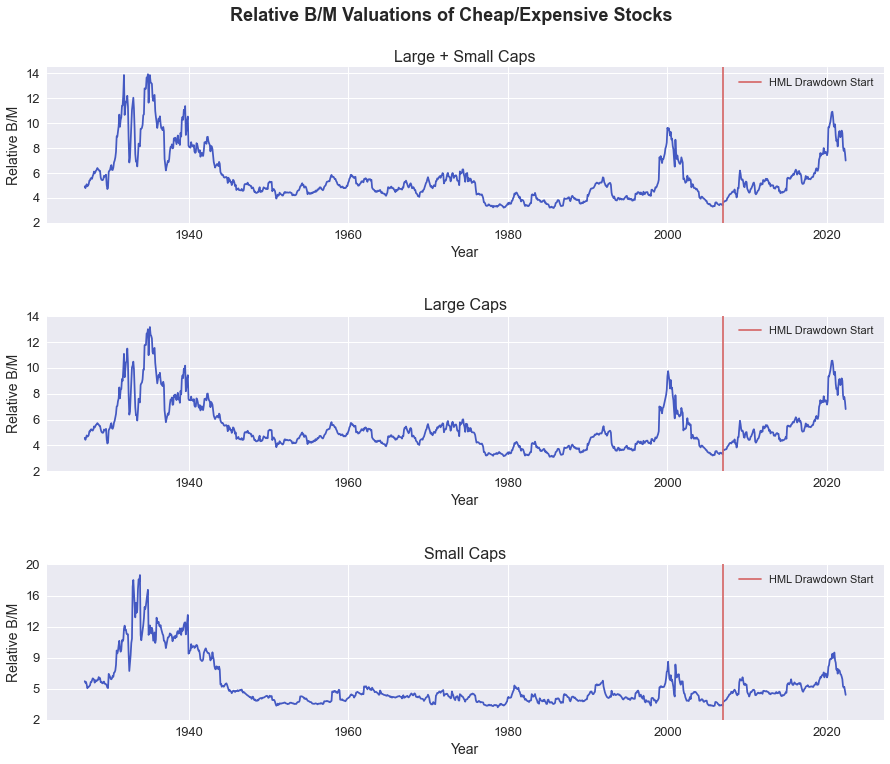

In [28]:
figure, axes = plt.subplots(3, figsize=(15,12))
plt.subplots_adjust(hspace=0.6)
figure.suptitle("Relative B/M Valuations of Cheap/Expensive Stocks", fontsize=18, fontweight="bold", y=0.95)

axes[0].plot(spreads["Valuation Spread All"], color="#4459c2")
axes[0].axvline(x=(2007-1970)*365, label="HML Drawdown Start", color="#d66b6b")

axes[0].set_title("Large + Small Caps", size=16)
axes[0].set_xlabel("Year", size=14)
axes[0].set_ylabel("Relative B/M", size=14)
axes[0].tick_params(axis="x", labelsize=13)

yticks = np.linspace(2, spreads["Valuation Spread All"].max() // 2 * 2 + 2, int(spreads["Valuation Spread All"].max() // 2)+1)
axes[0].set_yticks(yticks)
axes[0].set_yticklabels([int(tick) for tick in yticks], size=13)

axes[0].legend(fontsize=11, loc="upper right");

axes[1].plot(spreads["Valuation Spread Large"], color="#4459c2")
axes[1].axvline(x=(2007-1970)*365, label="HML Drawdown Start", color="#d66b6b")

axes[1].set_title("Large Caps", size=16)
axes[1].set_xlabel("Year", size=14)
axes[1].set_ylabel("Relative B/M", size=14)
axes[1].tick_params(axis="x", labelsize=13)

yticks = np.linspace(2, spreads["Valuation Spread Large"].max() // 2 * 2 + 2, int(spreads["Valuation Spread Large"].max() // 2)+1)
axes[1].set_yticks(yticks)
axes[1].set_yticklabels([int(tick) for tick in yticks], size=13)

axes[1].legend(fontsize=11, loc="upper right");

axes[2].plot(spreads["Valuation Spread Small"], color="#4459c2")
axes[2].axvline(x=(2007-1970)*365, label="HML Drawdown Start", color="#d66b6b")

axes[2].set_title("Small Caps", size=16)
axes[2].set_xlabel("Year", size=14)
axes[2].set_ylabel("Relative B/M", size=14)
axes[2].tick_params(axis="x", labelsize=13)

yticks = np.linspace(2, spreads["Valuation Spread Small"].max() // 2 * 2 + 2, int(spreads["Valuation Spread Small"].max() // 3))
axes[2].set_yticks(yticks)
axes[2].set_yticklabels([int(tick) for tick in yticks], size=13)

axes[2].legend(fontsize=11, loc="upper right");

The picture looks similar when using net-earnings or cashflows as the fundamental variable instead of book-values, although the widening is not as significant as for book-values. *(Again, the data starts later)*

In [29]:
spreads["High E/P Ratio"] = ep_sorted_data["Value Weight Average of E / ME"]["Hi 30"]
spreads["Low E/P Ratio"] = ep_sorted_data["Value Weight Average of E / ME"]["Lo 30"]

spreads["Large High E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["BIG HiEP"]
spreads["Large Low E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["BIG LoEP"]
spreads["Small High E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["SMALL HiEP"]
spreads["Small Low E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["SMALL LoEP"]

spreads["High CF/P Ratio"] = cfp_sorted_data["Value Weight Average of CF / ME"]["Hi 30"]
spreads["Low CF/P Ratio"] = cfp_sorted_data["Value Weight Average of CF / ME"]["Lo 30"]

spreads["Large High CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["BIG HiCFP"]
spreads["Large Low CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["BIG LoCFP"]
spreads["Small High CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["SMALL HiCFP"]
spreads["Small Low CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["SMALL LoCFP"]

for i, index in enumerate(df.index):
    if index in ep_sorted_data["Value Weight Returns Monthly"].index:
        if np.isnan(spreads.loc[index, "High E/P Ratio"]):
            spreads.loc[index, "High E/P Ratio"] = spreads.loc[df.index[i-1], "High E/P Ratio"] / (1+ep_sorted_data["Value Weight Returns Monthly"].loc[index, "Hi 30"]/100)
        if np.isnan(spreads.loc[index, "Low E/P Ratio"]):
            spreads.loc[index, "Low E/P Ratio"] = spreads.loc[df.index[i-1], "Low E/P Ratio"] / (1+ep_sorted_data["Value Weight Returns Monthly"].loc[index, "Lo 30"]/100)
    
    if index in ep_size_sorted_data["Value Weight Average Returns Monthly"].index:
        if np.isnan(spreads.loc[index, "Large High E/P Ratio"]):
            spreads.loc[index, "Large High E/P Ratio"] = spreads.loc[df.index[i-1], "Large High E/P Ratio"] / (1+ep_size_sorted_data["Value Weight Average Returns Monthly"].loc[index, "BIG HiEP"]/100)
        if np.isnan(spreads.loc[index, "Large Low E/P Ratio"]):
            spreads.loc[index, "Large Low E/P Ratio"] = spreads.loc[df.index[i-1], "Large Low E/P Ratio"] / (1+ep_size_sorted_data["Value Weight Average Returns Monthly"].loc[index, "BIG LoEP"]/100)
        if np.isnan(spreads.loc[index, "Small High E/P Ratio"]):
            spreads.loc[index, "Small High E/P Ratio"] = spreads.loc[df.index[i-1], "Small High E/P Ratio"] / (1+ep_size_sorted_data["Value Weight Average Returns Monthly"].loc[index, "SMALL HiEP"]/100)
        if np.isnan(spreads.loc[index, "Small Low E/P Ratio"]):
            spreads.loc[index, "Small Low E/P Ratio"] = spreads.loc[df.index[i-1], "Small Low E/P Ratio"] / (1+ep_size_sorted_data["Value Weight Average Returns Monthly"].loc[index, "SMALL LoEP"]/100)

    if index in cfp_sorted_data["Value Weight Returns Monthly"].index:
        if np.isnan(spreads.loc[index, "High CF/P Ratio"]):
            spreads.loc[index, "High CF/P Ratio"] = spreads.loc[df.index[i-1], "High CF/P Ratio"] / (1+cfp_sorted_data["Value Weight Returns Monthly"].loc[index, "Hi 30"]/100)
        if np.isnan(spreads.loc[index, "Large Low CF/P Ratio"]):
            spreads.loc[index, "Low CF/P Ratio"] = spreads.loc[df.index[i-1], "Low CF/P Ratio"] / (1+cfp_sorted_data["Value Weight Returns Monthly"].loc[index, "Lo 30"]/100)
            
    if index in cfp_size_sorted_data["Value Weight Average Returns Monthly"].index:
        if np.isnan(spreads.loc[index, "Large High CF/P Ratio"]):
            spreads.loc[index, "Large High CF/P Ratio"] = spreads.loc[df.index[i-1], "Large High CF/P Ratio"] / (1+cfp_size_sorted_data["Value Weight Average Returns Monthly"].loc[index, "BIG HiCFP"]/100)
        if np.isnan(spreads.loc[index, "Large Low CF/P Ratio"]):
            spreads.loc[index, "Large Low CF/P Ratio"] = spreads.loc[df.index[i-1], "Large Low CF/P Ratio"] / (1+cfp_size_sorted_data["Value Weight Average Returns Monthly"].loc[index, "BIG LoCFP"]/100)
        if np.isnan(spreads.loc[index, "Small High CF/P Ratio"]):
            spreads.loc[index, "Small High CF/P Ratio"] = spreads.loc[df.index[i-1], "Small High CF/P Ratio"] / (1+cfp_size_sorted_data["Value Weight Average Returns Monthly"].loc[index, "SMALL HiCFP"]/100)
        if np.isnan(spreads.loc[index, "Small Low CF/P Ratio"]):
            spreads.loc[index, "Small Low CF/P Ratio"] = spreads.loc[df.index[i-1], "Small Low CF/P Ratio"] / (1+cfp_size_sorted_data["Value Weight Average Returns Monthly"].loc[index, "SMALL LoCFP"]/100)

spreads["E/P Valuation Spread All"] = spreads["High E/P Ratio"] / spreads["Low E/P Ratio"]
spreads["E/P Valuation Spread Large"] = spreads["Large High E/P Ratio"] / spreads["Large Low E/P Ratio"]
spreads["E/P Valuation Spread Small"] = spreads["Small High E/P Ratio"] / spreads["Small Low E/P Ratio"]
spreads["CF/P Valuation Spread All"] = spreads["High CF/P Ratio"] / spreads["Low CF/P Ratio"]
spreads["CF/P Valuation Spread Large"] = spreads["Large High CF/P Ratio"] / spreads["Large Low CF/P Ratio"]
spreads["CF/P Valuation Spread Small"] = spreads["Small High CF/P Ratio"] / spreads["Small Low CF/P Ratio"]

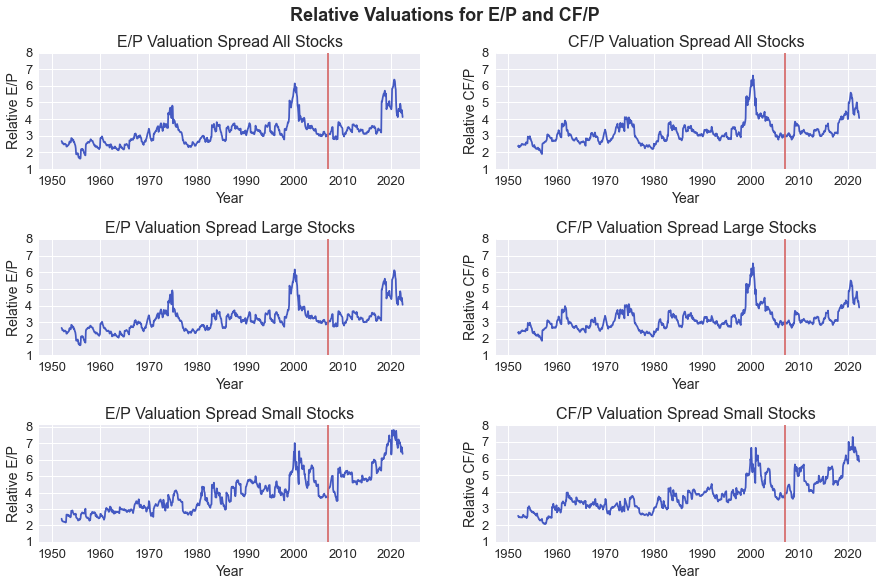

In [30]:
df["High E/P Ratio"] = ep_sorted_data["Value Weight Average of E / ME"]["Hi 30"]
df["Low E/P Ratio"] = ep_sorted_data["Value Weight Average of E / ME"]["Lo 30"]
df["E/P Valuation Spread All"] = (df["High E/P Ratio"] / df["Low E/P Ratio"]).ffill()

df["Large High E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["BIG HiEP"]
df["Large Low E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["BIG LoEP"]
df["E/P Valuation Spread Large"] = (df["Large High E/P Ratio"] / df["Large Low E/P Ratio"]).ffill()

df["Small High E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["SMALL HiEP"]
df["Small Low E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["SMALL LoEP"]
df["E/P Valuation Spread Small"] = (df["Small High E/P Ratio"] / df["Small Low E/P Ratio"]).ffill()

df["High CF/P Ratio"] = cfp_sorted_data["Value Weight Average of CF / ME"]["Hi 30"]
df["Low CF/P Ratio"] = cfp_sorted_data["Value Weight Average of CF / ME"]["Lo 30"]
df["CF/P Valuation Spread All"] = (df["High CF/P Ratio"] / df["Low CF/P Ratio"]).ffill()

df["Large High CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["BIG HiCFP"]
df["Large Low CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["BIG LoCFP"]
df["CF/P Valuation Spread Large"] = (df["Large High CF/P Ratio"] / df["Large Low CF/P Ratio"]).ffill()

df["Small High CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["SMALL HiCFP"]
df["Small Low CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["SMALL LoCFP"]
df["CF/P Valuation Spread Small"] = (df["Small High CF/P Ratio"] / df["Small Low CF/P Ratio"]).ffill()


figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,9))
plt.subplots_adjust(hspace=0.6)
figure.suptitle("Relative Valuations for E/P and CF/P", fontsize=18, fontweight="bold", y=0.95)

for row, dataset in enumerate((
    "E/P Valuation Spread All",
    "E/P Valuation Spread Large",
    "E/P Valuation Spread Small"
)):

    axes[row, 0].plot(spreads[dataset], color="#4459c2")
    axes[row, 0].axvline(x=(2007-1970)*365, color="#d66b6b")
    axes[row, 0].set_title(f"{dataset} Stocks", size=16)
    axes[row, 0].set_xlabel("Year", size=14)
    yticks = [1,2,3,4,5,6,7,8]
    axes[row, 0].set_yticks(yticks)
    axes[row, 0].set_yticklabels([int(tick) for tick in yticks], size=13)
    axes[row, 0].set_ylabel(f"Relative {dataset.split()[0]}", size=14)
    axes[row, 0].tick_params(axis="both", labelsize=13)

for row, dataset in enumerate((
    "CF/P Valuation Spread All",
    "CF/P Valuation Spread Large",
    "CF/P Valuation Spread Small"
)):
    axes[row, 1].plot(spreads[dataset], color="#4459c2")
    axes[row, 1].axvline(x=(2007-1970)*365, color="#d66b6b")
    axes[row, 1].set_title(f"{dataset} Stocks", size=16)
    axes[row, 1].set_xlabel("Year", size=14)
    yticks = [1,2,3,4,5,6,7,8]
    axes[row, 1].set_yticks(yticks)
    axes[row, 1].set_yticklabels([int(tick) for tick in yticks], size=13)
    axes[row, 1].set_ylabel(f"Relative {dataset.split()[0]}", size=14)
    axes[row, 1].tick_params(axis="both", labelsize=13)

This indicates that the value premium during the last 15 years was to a large extent driven by changing relative valuations between cheap and expensive stocks. The "fundamental" value premium that accounts for explaining factors of the changing relative valuations therefore might not have been as bad as it first seems.

Turning to the question whether cheap stocks are historically cheap or expensive stocks are historically expensive, we can compute the z-score of the respective valuation metric. Because I use variable/market value instead of the often used reciprocal (e.g. price/earnings multiple), positive z-scores indicate historically cheap valuations since we get more fundamental value per amount of market value.

In [76]:
z_scores = {
    "High": pd.DataFrame(index = ["B/M", "E/P", "CF/P"], columns=["All", "Large", "Small"]),
    "Low": pd.DataFrame(index = ["B/M", "E/P", "CF/P"], columns=["All", "Large", "Small"])
}
z_scores["High"].index.name = "Cheap Stocks"
z_scores["Low"].index.name = "Expensive Stocks"
for breakpoint in z_scores.keys():
    for var in z_scores[breakpoint].index:
        for cap in z_scores[breakpoint].columns:
            if cap == "All":
                name = f"{breakpoint} {var} Ratio"
            else:
                name = f"{cap} {breakpoint} {var} Ratio"
            z_scores[breakpoint].loc[var, cap] = (spreads[name][-1] - spreads[name].mean()) / spreads[name].std()
display(z_scores["High"].applymap(lambda x: round(x, 2)))
display(z_scores["Low"].applymap(lambda x: round(x, 2)))

,All,Large,Small
Cheap Stocks,,,
B/M,-0.71,-0.75,-0.58
E/P,-1.03,-1.08,-0.75
CF/P,-1.41,-1.44,-1.28


,All,Large,Small
Expensive Stocks,,,
B/M,-1.38,-1.39,-0.92
E/P,-1.29,-1.32,-1.23
CF/P,-1.47,-1.46,-1.38


Both cheap and expensive stocks are pricey compared to their historical averages, which, given the current low rate environment, is not suprising. However, expensive stocks seem to be disproportionately expensive based on book-value/market-value and earnings/price ratios and they are the reason for the widening valuation spreads.

## 4.&nbsp;Explaining&nbsp;Variables

Because the change in relative valuations of cheap and expensive stocks has a big impact on the realized premium, we should analyze the value premium adjusted for changes in the state vector that contains variables that describe the current market environment and affect relative valuations.
<br>
The naive way to do so is to adjust the premium by subtracting the change in valuation. For example, when the value premium returns 100% and expensive stocks double their relative valuation compared to cheap stocks, the adjusted premium would be zero. However, this would ignore changes in expectations that justify changes in relative valuations and the adjusted premium would be biased.
<br>
A better way is therefore to find variables that affect relative valuations, adjust the valuation spread to those variables and subtract the adjusted valuation spread from the value premium to compute a "fundamental" value premium.

Starting with the simple pricing equation, any asset price should equal the sum of all excess cashflows it will generate during its lifetime, discounted to the present.
<br>
<br>
$$ Market\;Value = \sum \limits_{t=1} ^{\infty} \frac{Free\;Cashflow_t}{(1+Discount\;Rate_t)^{t}} $$
<br>
Assuming a flat term structure of discount rates, a constant growth rate of free-cashflows and that the discount rate is higher than the growth rate, the resulting geometric series can be simplified to
<br>
<br>
$$ Market\;Value = \frac{Free\;Cashflow}{Discount\;Rate-Growth\;Rate} $$
<br>
The discount rate of any asset consists of its risk premium and the rate one would get on a riskless asset.
<br>
<br>
$$ Market\;Value = \frac{Free\;Cashflow}{Riskfree\;Rate+Risk\;Premium-Growth\;Rate} $$
<br>
The growth rate of the free cashflows is governed by the reinvestment rate scaled by profitability. If all earnings are reinvested with a return on equity (and assuming constant leverage) of 10%, then the growth rate of free-cashflows and earnings has to be 10%. Likewise, if only 50% of cashflows are reinvested, the growth rate would be 5%.
<br>
<br>
$$ Market\;Value = \frac{Free\;Cashflow}{Riskfree\;Rate+Risk\;Premium-Reinvestment\;Rate*Return\;On\;Equity} $$
<br>
Rearranging gives
<br>
<br>
$$ \frac{Free\;Cashflow}{Market\;Value} = Riskfree\;Rate+Risk\;Premium-Reinvestment\;Rate*Return\;On\;Equity $$
<br>
Since $Free\;Cashflow = (1 + Reinvestment\;Rate) * Earnings$, we get
<br>
<br>
$$ \frac{Earnings}{Market\;Value} = (Riskfree\;Rate+Risk\;Premium-Reinvestment\;Rate*Return\;On\;Equity) * \frac{1}{1-Reinvestment\;Rate} $$
<br>
Operating Cashflows equal Earnings after Working Capital changes, which in most cases should not be too large and hence can be ignored so that we can also write
<br>
<br>
$$ \frac{Operating\;Cashflow}{Market\;Value} = (Riskfree\;Rate+Risk\;Premium-Reinvestment\;Rate*Return\;On\;Equity) * \frac{1}{1-Reinvestment\;Rate} $$
<br>
Book-Values and Earnings are related via the Return on Equity. Thus, we can also consider Book-to-Market ratios:
<br>
<br>
$$ \frac{Book\;Value}{Market\;Value} = (Riskfree\;Rate+Risk\;Premium-Reinvestment\;Rate*Return\;On\;Equity) * \frac{1}{(1-Reinvestment\;Rate)*Return\;On\;Equity} $$

The conclusion is that the amount of earnings, cashflows or book-value one gets for every amount of market value increases with the risk-free rate, increases with the risk premium and decreases with the return on equity.
<br>
Terefore the valuation spread between cheap and expensive stocks (e.g. book-to-market ratios of cheap stocks divided by book-to-market ratios of expensive stocks)
1. increases with the risk premium differential between cheap and expensive stocks
2. decreases with the profitability difference between cheap and expensive stocks
*The relationship between valuation ratios and reinvestment rate depends on the values of the discount rate and profitability. Because Kenneth French does not provide data on reinvestment rates anyways, I ignore it.*

In addition, expensive stocks tend to grow faster than cheap stocks and hence have a higher portion of their net present value in the distant future than cheap stocks. That is why expensive stocks are more interest-rate sensitive (i.e. have a higher duration) than cheap stocks. For example, at a discount rate of 5%, the net present value of 100 dollar in 10 (30) years would be 61.39 (23.14). An increase of 1% in the discount rate would change net present values to 55.84 and 17.41, resulting in relative changes of -9.05% and -24.76%, respectively.
<br>
Because risk-free rates are generally not constant across all maturities, cashflows across different maturities are discounted with different rates. The implication is that, even though the yield curve shifts upwards, cheap stocks could drop more than expensive stocks if short-term rates rise much faster (or drop much less) than long-term rates.
<br>
We can hence disentangle the partial effects of the yield curve on valuation spreads by stating that

3. the higher the base of the yield curve (i.e. the T-bill or short-term T-note rate), the lower are valuation spreads of cheap and expensive stocks
4. the steeper the yield curve, the higher are valuation spreads of expensive and cheap stocks

## 5.&nbsp;Time-Series&nbsp;Predictability

## 6.&nbsp;ETF/Stock&nbsp;Selection

## 7.&nbsp;Summary